# Time Series Analysis & Recurrent Neural Networks
## Final Project
### Lars Kühmichel, Nicolas Wolf

The final project is about analyzing the dynamics of a time series of weather data from across Europe. The goal is to
- reconstruct the dynamics behind the data, especially the annual and daily rhythms
- predict the future of the time series
- and compare two model architectures with respect to the results.

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pathlib as pl
import seaborn as sns
import torch
import torch.nn as nn
import pytorch_lightning as lightning
import pytorch_lightning.loggers as loggers
from torch.utils.data import DataLoader, Dataset

import ray.tune as tune
from ray.tune.integration.pytorch_lightning import TuneReportCallback

In [61]:
plt.rc("figure", dpi=200)
plt.rc("legend", fontsize=6)

We first run a modified version of the provided code to download the dataset and save it locally.

In [62]:
def running_mean(x, N):
    w = np.ones(N) / N
    if x.ndim > 1:
        res = []
        for i in range(x.shape[1]):
            res.append(np.convolve(w, x[:, i], 'valid'))
        return np.array(res).T
    else:
        return np.convolve(w, x, 'valid')

In [63]:
data_root = pl.Path("data")
data_root.mkdir(exist_ok=True, parents=True)

data_path = data_root / "weather_data.csv"

if not data_path.is_file():
    data_url = r"https://data.open-power-system-data.org/weather_data/2020-09-16/weather_data.csv"
    data = pd.read_csv(data_url)
    data.to_csv(data_path)
else:
    data = pd.read_csv(data_path)

The dataset contains hourly geographically aggregated weather (radiation and temperature) data for Europe. It covers the European countries using a population-weighted mean across all MERRA-2 grid cells within the given country.

In [64]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350640 entries, 0 to 350639
Data columns (total 86 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   Unnamed: 0                       350640 non-null  int64  
 1   utc_timestamp                    350640 non-null  object 
 2   AT_temperature                   350640 non-null  float64
 3   AT_radiation_direct_horizontal   350640 non-null  float64
 4   AT_radiation_diffuse_horizontal  350640 non-null  float64
 5   BE_temperature                   350640 non-null  float64
 6   BE_radiation_direct_horizontal   350640 non-null  float64
 7   BE_radiation_diffuse_horizontal  350640 non-null  float64
 8   BG_temperature                   350640 non-null  float64
 9   BG_radiation_direct_horizontal   350640 non-null  float64
 10  BG_radiation_diffuse_horizontal  350640 non-null  float64
 11  CH_temperature                   350640 non-null  float64
 12  CH

In [65]:
keys = [
    "FI_temperature",
    "DE_temperature",
    "GR_temperature"
]

test_temp = data[keys]

In [66]:
ten_years = 24 * 365 * 10
tdf = test_temp[-ten_years:]

In [67]:
# weekly mask
week_filter = [True] * 24 + [False] * 24 * 6
# yearly mask for 52 weeks plus one day
year_filter = week_filter * 52 + [True] * 24
# mask for ten years
ten_years_filter = year_filter * 10
daydf = tdf[ten_years_filter]

daydf.shape

(12720, 3)

In [68]:
npa = daydf.to_numpy()

In [69]:
#Moving average to see both trends
N = 24
mnpa = running_mean(npa, N)

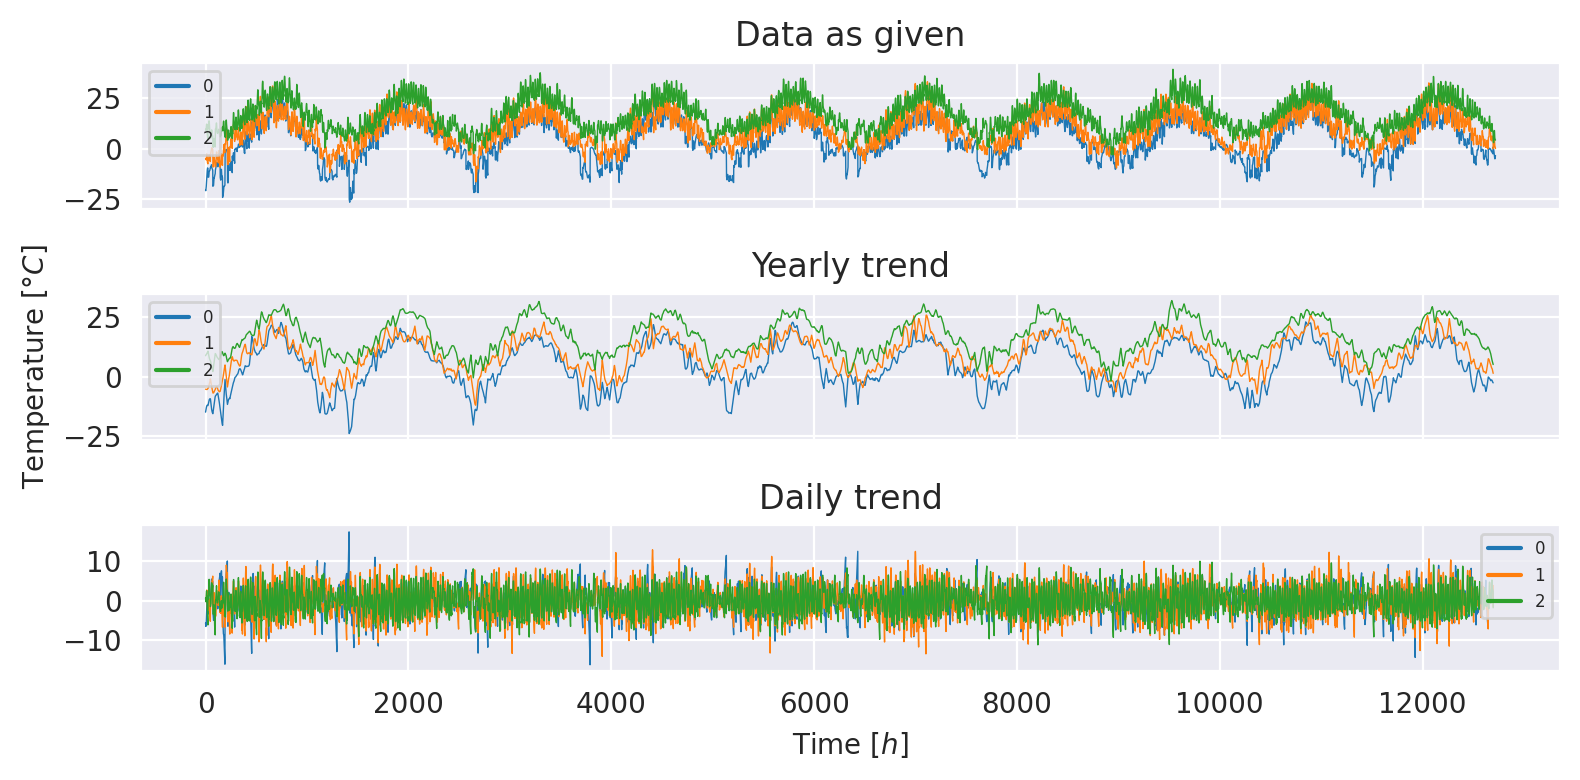

In [70]:
fig, axes = plt.subplots(nrows=3, ncols=1, sharex="all", figsize=plt.figaspect(1 / 2))
sns.lineplot(data=npa, ax=axes[0], dashes=False, lw=0.5)
axes[0].set_title("Data as given")

sns.lineplot(data=mnpa, ax=axes[1], dashes=False, lw=0.5)
axes[1].set_title("Yearly trend")
axes[1].set_ylabel("Temperature $[°C]$")

sns.lineplot(data=npa[:-N + 1] - mnpa, ax=axes[2], dashes=False, lw=0.5)
axes[2].set_title("Daily trend")
axes[2].set_xlabel("Time $[h]$")

plt.tight_layout()

In [71]:
pivot = int(0.8 * len(npa))

train_data, test_data = npa[:pivot], npa[pivot:]

train_data.shape, test_data.shape

((10176, 3), (2544, 3))

### 3. Use a deterministic LSTM coupled with a fully connected observation layer and optimize it with backpropagation through time

In [72]:
"""
Best hyperparameters found were: {'input_size': 3, 'hidden_size': 32, 'num_layers': 1, 'dropout': 0.4321135181028717, 'batch_size': 4, 'optimizer': 'rmsprop', 'learning_rate': 0.0032696303188682646, 'gradient_clip': None, 'sequence_length': 96, 'lr_warmup_milestones': [], 'lr_warmup_gamma': 10.0, 'lr_milestones': [], 'lr_gamma': 0.1, 'layers': 2}
"""

hparams = dict(
    input_size=npa.shape[-1],
    # choose hidden size small enough for fast training
    hidden_size=32,
    # choose number of layers small enough for fast training
    num_layers=1,
    # choose dropout small enough to not hinder network capacity
    dropout=0.4,
    # choose batch size large enough to smooth out gradients
    batch_size=4,
    optimizer="rmsprop",
    # we use the default learning rate
    learning_rate=3e-3,
    # gradient clipping can help with very noisy loss landscapes
    gradient_clip=None,
    # choose sequence length large enough to capture periodicities in the data
    sequence_length=4 * 24,
    # lr warmup can help with very noisy loss landscapes
    lr_warmup_milestones=[],
    lr_warmup_gamma=10.0,
    # lr milestones help push the network deeper into the loss minimum
    lr_milestones=[],
    lr_gamma=0.1,
)

In [73]:
class TimeSeriesDataset(Dataset):
    def __init__(self, time_series: torch.Tensor, sequence_length: int):
        self.time_series = time_series
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.time_series) - self.sequence_length + 1

    def __getitem__(self, item):
        start = item
        stop = item + self.sequence_length
        return self.time_series[start:stop]

train_data = torch.tensor(train_data, dtype=torch.float32)
val_data = torch.tensor(test_data, dtype=torch.float32)

In [74]:
class LSTM(lightning.LightningModule):
    def __init__(self, train_data, val_data, **hparams):
        super().__init__()
        self.save_hyperparameters(hparams, ignore=["train_data", "val_data"])

        self.train_data = TimeSeriesDataset(train_data, self.hparams.sequence_length)
        self.val_data = TimeSeriesDataset(val_data, self.hparams.sequence_length)

        self.lstm = nn.LSTM(self.hparams.input_size, self.hparams.hidden_size, self.hparams.num_layers, dropout=self.hparams.dropout, batch_first=True)
        self.observation_net = nn.Sequential(
            nn.Linear(self.hparams.hidden_size, self.hparams.input_size),
        )

        self.loss = nn.MSELoss()

    def forward(self, x):
        z, _ = self.lstm.forward(x)
        y = self.observation_net.forward(z)

        return y

    def training_step(self, batch, batch_idx):
        y = self.forward(batch[:, :-1])
        loss = self.loss(y, batch[:, 1:])

        self.log("train_loss", loss)

        return loss

    def validation_step(self, batch, batch_idx):
        y = self.forward(batch[:, :-1])
        loss = self.loss(y, batch[:, 1:])

        self.log("val_loss", loss)

    def predict(self, x:  torch.Tensor, hx=None, steps: int = 1):
        predictions = []
        x = x[:, -self.hparams.sequence_length:].to(self.device)

        for _ in range(steps):
            z, hx = self.lstm.forward(x, hx)
            x = self.observation_net(z).detach()

            predictions.append(x[:, -1])

        return torch.stack(predictions, dim=1)

    def forecast(self, steps: int = 1):
        return self.predict(self.train_data.time_series[None], steps=steps).squeeze()

    def configure_optimizers(self):
        match self.hparams.optimizer.lower():
            case "adam":
                optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate)
            case "rmsprop":
                optimizer = torch.optim.RMSprop(self.parameters(), lr=self.hparams.learning_rate)
            case _:
                raise ValueError(f"Optimizer {self.hparams.optimizer} is not supported.")

        lr_warmup = torch.optim.lr_scheduler.MultiStepLR(optimizer, self.hparams.lr_warmup_milestones, self.hparams.lr_warmup_gamma)
        lr_step = torch.optim.lr_scheduler.MultiStepLR(optimizer, self.hparams.lr_milestones, self.hparams.lr_gamma)
        lr_scheduler = torch.optim.lr_scheduler.ChainedScheduler([
            lr_warmup,
            lr_step,
        ])
        return dict(
            optimizer=optimizer,
            lr_scheduler=lr_scheduler,
        )

    def configure_callbacks(self):
        return [
            lightning.callbacks.ModelCheckpoint(monitor="val_loss", save_last=True),
            lightning.callbacks.LearningRateMonitor(),
            lightning.callbacks.StochasticWeightAveraging(),
        ]

    def train_dataloader(self):
        return DataLoader(
            dataset=self.train_data,
            batch_size=self.hparams.batch_size,
            shuffle=True,
            pin_memory=True,
            num_workers=4,
        )

    def val_dataloader(self):
        return DataLoader(
            dataset=self.val_data,
            batch_size=self.hparams.batch_size,
            shuffle=False,
            pin_memory=True,
            num_workers=4,
        )

In [75]:
def train(hparams, metrics, max_epochs=16, gpus=-1):
    model = LSTM(train_data, val_data, **hparams)

    logger = loggers.TensorBoardLogger(
        save_dir=tune.get_trial_dir(), name="", version="."
    )

    trainer = lightning.Trainer(
        max_epochs=max_epochs,
        gpus=gpus,
        callbacks=[
            TuneReportCallback(metrics=metrics, on="validation_end")
        ],
        logger=logger,
        enable_progress_bar=False,
    )

    trainer.fit(model)

    return model

In [76]:
def tune_hparams(config, metrics, num_samples=10, max_epochs=16, gpus_per_trial=1):
    scheduler = tune.schedulers.AsyncHyperBandScheduler(
        max_t=max_epochs,
        grace_period=4,
        reduction_factor=2,
    )

    reporter = tune.CLIReporter(
        parameter_columns=list(config.keys()),
        metric_columns=list(metrics.keys()) + ["training_iteration"],
    )

    train_fn = tune.with_parameters(train, metrics=metrics, max_epochs=max_epochs, gpus=gpus_per_trial)
    resources_per_trial = dict(cpu=1, gpu=gpus_per_trial)
    analysis = tune.run(
        train_fn,
        resources_per_trial=resources_per_trial,
        metric="loss",
        mode="min",
        config=config,
        num_samples=num_samples,
        scheduler=scheduler,
        progress_reporter=reporter,
        name="tune_asha",
    )

    return analysis

Run a hyperparameter search

In [77]:
metrics = dict(
    loss="val_loss",
)

config = hparams.copy()
config["optimizer"] = tune.choice(["adam", "rmsprop"])
config["hidden_size"] = tune.choice([32, 64, 128, 256])
config["num_layers"] = tune.choice([1, 2, 4, 8])
config["sequence_length"] = tune.choice([24, 4 * 24, 12 * 24])
config["learning_rate"] = tune.loguniform(1e-4, 1e-2)
config["batch_size"] = tune.choice([4, 16, 64])
config["dropout"] = tune.uniform(0, 0.5)

In [78]:
analysis = tune_hparams(config, metrics)

== Status ==
Current time: 2022-07-31 17:32:34 (running for 00:00:00.15)
Memory usage on this node: 15.5/31.3 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: None | Iter 4.000: None
Resources requested: 1.0/16 CPUs, 1.0/1 GPUs, 0.0/10.78 GiB heap, 0.0/5.39 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/lars/ray_results/tune_asha
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-------------------+----------+-----------------------+--------------+---------------+--------------+-----------+--------------+-------------+-----------------+-----------------+-------------------+------------------------+-------------------+-----------------+------------+
| Trial name        | status   | loc                   |   input_size |   hidden_size |   num_layers |   dropout |   batch_size | optimizer   |   learning_rate | gradient_clip   |   sequence_length | lr_warmup_milestones   |   lr_warmup_gamma | lr_milestones   |   lr_gamma |
|-------------------+-

(train pid=177193) /home/lars/code/python/TSA-RNN-final-project/.venv/lib/python3.10/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.034684173151442954 and num_layers=1
(train pid=177193)   warnings.warn("dropout option adds dropout after all but last "
(train pid=177193) GPU available: True, used: True
(train pid=177193) TPU available: False, using: 0 TPU cores
(train pid=177193) IPU available: False, using: 0 IPUs
(train pid=177193) HPU available: False, using: 0 HPUs
(train pid=177193) The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
(train pid=177193) /home/lars/code/python/TSA-RNN-final-project/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:335: LightningDeprecationWarning: The `on_keyboard_interrupt` callba

Result for train_ffe26_00000:
  date: 2022-07-31_17-32-38
  done: false
  experiment_id: cf12d3ac3bdd427fb577672cccc30ec2
  hostname: lars-desktop
  iterations_since_restore: 1
  loss: 21.081872940063477
  node_ip: 192.168.178.30
  pid: 177193
  time_since_restore: 1.953141212463379
  time_this_iter_s: 1.953141212463379
  time_total_s: 1.953141212463379
  timestamp: 1659281558
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: ffe26_00000
  warmup_time: 0.001596212387084961
  
== Status ==
Current time: 2022-07-31 17:32:39 (running for 00:00:05.44)
Memory usage on this node: 17.7/31.3 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: None | Iter 4.000: -1.7960751056671143
Resources requested: 1.0/16 CPUs, 1.0/1 GPUs, 0.0/10.78 GiB heap, 0.0/5.39 GiB objects (0.0/1.0 accelerator_type:G)
Current best trial: ffe26_00000 with loss=1.7960751056671143 and parameters={'input_size': 3, 'hidden_size': 64, 'num_layers': 1, 'dropout': 0.034684173151442

(train pid=177193) Swapping scheduler `ChainedScheduler` for `SWALR`


== Status ==
Current time: 2022-07-31 17:32:45 (running for 00:00:11.05)
Memory usage on this node: 17.7/31.3 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: -0.9155054092407227 | Iter 4.000: -1.7960751056671143
Resources requested: 1.0/16 CPUs, 1.0/1 GPUs, 0.0/10.78 GiB heap, 0.0/5.39 GiB objects (0.0/1.0 accelerator_type:G)
Current best trial: ffe26_00000 with loss=0.74055415391922 and parameters={'input_size': 3, 'hidden_size': 64, 'num_layers': 1, 'dropout': 0.034684173151442954, 'batch_size': 64, 'optimizer': 'rmsprop', 'learning_rate': 0.001144888695715917, 'gradient_clip': None, 'sequence_length': 96, 'lr_warmup_milestones': [], 'lr_warmup_gamma': 10.0, 'lr_milestones': [], 'lr_gamma': 0.1}
Result logdir: /home/lars/ray_results/tune_asha
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-------------------+----------+-----------------------+--------------+---------------+--------------+-----------+--------------+-------------+-----------------+----

(train pid=177900) GPU available: True, used: True
(train pid=177900) TPU available: False, using: 0 TPU cores
(train pid=177900) IPU available: False, using: 0 IPUs
(train pid=177900) HPU available: False, using: 0 HPUs
(train pid=177900) The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
(train pid=177900) /home/lars/code/python/TSA-RNN-final-project/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:335: LightningDeprecationWarning: The `on_keyboard_interrupt` callback hook was deprecated in v1.5 and will be removed in v1.7. Please use the `on_exception` callback hook instead.
(train pid=177900)   rank_zero_deprecation(
(train pid=177900) /home/lars/code/python/TSA-RNN-final-project/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:347: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.

Result for train_ffe26_00001:
  date: 2022-07-31_17-32-52
  done: false
  experiment_id: 80df143c22fe4703902199207e96659f
  hostname: lars-desktop
  iterations_since_restore: 1
  loss: 159.69338989257812
  node_ip: 192.168.178.30
  pid: 177900
  time_since_restore: 2.456315755844116
  time_this_iter_s: 2.456315755844116
  time_total_s: 2.456315755844116
  timestamp: 1659281572
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: ffe26_00001
  warmup_time: 0.0015850067138671875
  
== Status ==
Current time: 2022-07-31 17:32:52 (running for 00:00:17.77)
Memory usage on this node: 19.9/31.3 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 16.000: -0.7358866930007935 | Iter 8.000: -0.9155054092407227 | Iter 4.000: -1.7960751056671143
Resources requested: 1.0/16 CPUs, 1.0/1 GPUs, 0.0/10.78 GiB heap, 0.0/5.39 GiB objects (0.0/1.0 accelerator_type:G)
Current best trial: ffe26_00000 with loss=0.7358866930007935 and parameters={'input_size': 3, 'hidden_size': 64, 'num_layers': 

(train pid=178173) GPU available: True, used: True
(train pid=178173) TPU available: False, using: 0 TPU cores
(train pid=178173) IPU available: False, using: 0 IPUs
(train pid=178173) HPU available: False, using: 0 HPUs
(train pid=178173) The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
(train pid=178173) /home/lars/code/python/TSA-RNN-final-project/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:335: LightningDeprecationWarning: The `on_keyboard_interrupt` callback hook was deprecated in v1.5 and will be removed in v1.7. Please use the `on_exception` callback hook instead.
(train pid=178173)   rank_zero_deprecation(
(train pid=178173) /home/lars/code/python/TSA-RNN-final-project/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:347: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.

== Status ==
Current time: 2022-07-31 17:33:01 (running for 00:00:26.86)
Memory usage on this node: 17.7/31.3 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 16.000: -0.7358866930007935 | Iter 8.000: -0.9155054092407227 | Iter 4.000: -48.3081556558609
Resources requested: 1.0/16 CPUs, 1.0/1 GPUs, 0.0/10.78 GiB heap, 0.0/5.39 GiB objects (0.0/1.0 accelerator_type:G)
Current best trial: ffe26_00000 with loss=0.7358866930007935 and parameters={'input_size': 3, 'hidden_size': 64, 'num_layers': 1, 'dropout': 0.034684173151442954, 'batch_size': 64, 'optimizer': 'rmsprop', 'learning_rate': 0.001144888695715917, 'gradient_clip': None, 'sequence_length': 96, 'lr_warmup_milestones': [], 'lr_warmup_gamma': 10.0, 'lr_milestones': [], 'lr_gamma': 0.1}
Result logdir: /home/lars/ray_results/tune_asha
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+-------------------+------------+-----------------------+--------------+---------------+--------------+-----------+--------------+-----

(train pid=178596) GPU available: True, used: True
(train pid=178596) TPU available: False, using: 0 TPU cores
(train pid=178596) IPU available: False, using: 0 IPUs
(train pid=178596) HPU available: False, using: 0 HPUs
(train pid=178596) The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
(train pid=178596) /home/lars/code/python/TSA-RNN-final-project/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:335: LightningDeprecationWarning: The `on_keyboard_interrupt` callback hook was deprecated in v1.5 and will be removed in v1.7. Please use the `on_exception` callback hook instead.
(train pid=178596)   rank_zero_deprecation(
(train pid=178596) /home/lars/code/python/TSA-RNN-final-project/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:347: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.

Result for train_ffe26_00003:
  date: 2022-07-31_17-33-29
  done: false
  experiment_id: 52d2c05e9d5e4bb0a0ec6d56c5ec7301
  hostname: lars-desktop
  iterations_since_restore: 1
  loss: 87.51419830322266
  node_ip: 192.168.178.30
  pid: 178596
  time_since_restore: 3.527813196182251
  time_this_iter_s: 3.527813196182251
  time_total_s: 3.527813196182251
  timestamp: 1659281609
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: ffe26_00003
  warmup_time: 0.0015861988067626953
  
== Status ==
Current time: 2022-07-31 17:33:29 (running for 00:00:54.82)
Memory usage on this node: 17.7/31.3 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 16.000: -0.7358866930007935 | Iter 8.000: -2.9498753547668457 | Iter 4.000: -6.8839945793151855
Resources requested: 1.0/16 CPUs, 1.0/1 GPUs, 0.0/10.78 GiB heap, 0.0/5.39 GiB objects (0.0/1.0 accelerator_type:G)
Current best trial: ffe26_00000 with loss=0.7358866930007935 and parameters={'input_size': 3, 'hidden_size': 64, 'num_layers': 1

(train pid=178871) GPU available: True, used: True
(train pid=178871) TPU available: False, using: 0 TPU cores
(train pid=178871) IPU available: False, using: 0 IPUs
(train pid=178871) HPU available: False, using: 0 HPUs
(train pid=178871) The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
(train pid=178871) /home/lars/code/python/TSA-RNN-final-project/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:335: LightningDeprecationWarning: The `on_keyboard_interrupt` callback hook was deprecated in v1.5 and will be removed in v1.7. Please use the `on_exception` callback hook instead.
(train pid=178871)   rank_zero_deprecation(
(train pid=178871) /home/lars/code/python/TSA-RNN-final-project/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:347: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.

Result for train_ffe26_00004:
  date: 2022-07-31_17-33-39
  done: false
  experiment_id: 5ed2943b5eac46b9bf9309c22717bb22
  hostname: lars-desktop
  iterations_since_restore: 1
  loss: 109.82542419433594
  node_ip: 192.168.178.30
  pid: 178871
  time_since_restore: 2.0197110176086426
  time_this_iter_s: 2.0197110176086426
  time_total_s: 2.0197110176086426
  timestamp: 1659281619
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: ffe26_00004
  warmup_time: 0.0016300678253173828
  
== Status ==
Current time: 2022-07-31 17:33:41 (running for 00:01:06.75)
Memory usage on this node: 17.7/31.3 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 16.000: -0.7358866930007935 | Iter 8.000: -2.9498753547668457 | Iter 4.000: -10.251935720443726
Resources requested: 1.0/16 CPUs, 1.0/1 GPUs, 0.0/10.78 GiB heap, 0.0/5.39 GiB objects (0.0/1.0 accelerator_type:G)
Current best trial: ffe26_00000 with loss=0.7358866930007935 and parameters={'input_size': 3, 'hidden_size': 64, 'num_layers

(train pid=179145) GPU available: True, used: True
(train pid=179145) TPU available: False, using: 0 TPU cores
(train pid=179145) IPU available: False, using: 0 IPUs
(train pid=179145) HPU available: False, using: 0 HPUs
(train pid=179145) The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
(train pid=179145) /home/lars/code/python/TSA-RNN-final-project/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:335: LightningDeprecationWarning: The `on_keyboard_interrupt` callback hook was deprecated in v1.5 and will be removed in v1.7. Please use the `on_exception` callback hook instead.
(train pid=179145)   rank_zero_deprecation(
(train pid=179145) /home/lars/code/python/TSA-RNN-final-project/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:347: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.

== Status ==
Current time: 2022-07-31 17:33:47 (running for 00:01:12.87)
Memory usage on this node: 17.7/31.3 GiB
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 16.000: -0.7358866930007935 | Iter 8.000: -2.9498753547668457 | Iter 4.000: -13.619876861572266
Resources requested: 1.0/16 CPUs, 1.0/1 GPUs, 0.0/10.78 GiB heap, 0.0/5.39 GiB objects (0.0/1.0 accelerator_type:G)
Current best trial: ffe26_00000 with loss=0.7358866930007935 and parameters={'input_size': 3, 'hidden_size': 64, 'num_layers': 1, 'dropout': 0.034684173151442954, 'batch_size': 64, 'optimizer': 'rmsprop', 'learning_rate': 0.001144888695715917, 'gradient_clip': None, 'sequence_length': 96, 'lr_warmup_milestones': [], 'lr_warmup_gamma': 10.0, 'lr_milestones': [], 'lr_gamma': 0.1}
Result logdir: /home/lars/ray_results/tune_asha
Number of trials: 10/10 (4 PENDING, 1 RUNNING, 5 TERMINATED)
+-------------------+------------+-----------------------+--------------+---------------+--------------+-----------+--------------+---

(train pid=179145) Swapping scheduler `ChainedScheduler` for `SWALR`


Result for train_ffe26_00005:
  date: 2022-07-31_17-34-31
  done: false
  experiment_id: 4d5f0380ecd04ba5955eeebfeb8df2d0
  hostname: lars-desktop
  iterations_since_restore: 13
  loss: 0.8962732553482056
  node_ip: 192.168.178.30
  pid: 179145
  time_since_restore: 47.51995396614075
  time_this_iter_s: 3.6094248294830322
  time_total_s: 47.51995396614075
  timestamp: 1659281671
  timesteps_since_restore: 0
  training_iteration: 13
  trial_id: ffe26_00005
  warmup_time: 0.0015869140625
  
== Status ==
Current time: 2022-07-31 17:34:31 (running for 00:01:56.83)
Memory usage on this node: 17.7/31.3 GiB
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 16.000: -0.7358866930007935 | Iter 8.000: -1.0539168119430542 | Iter 4.000: -10.251935720443726
Resources requested: 1.0/16 CPUs, 1.0/1 GPUs, 0.0/10.78 GiB heap, 0.0/5.39 GiB objects (0.0/1.0 accelerator_type:G)
Current best trial: ffe26_00000 with loss=0.7358866930007935 and parameters={'input_size': 3, 'hidden_size': 64, 'num_layers': 1, 

(train pid=179877) GPU available: True, used: True
(train pid=179877) TPU available: False, using: 0 TPU cores
(train pid=179877) IPU available: False, using: 0 IPUs
(train pid=179877) HPU available: False, using: 0 HPUs
(train pid=179877) The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
(train pid=179877) /home/lars/code/python/TSA-RNN-final-project/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:335: LightningDeprecationWarning: The `on_keyboard_interrupt` callback hook was deprecated in v1.5 and will be removed in v1.7. Please use the `on_exception` callback hook instead.
(train pid=179877)   rank_zero_deprecation(
(train pid=179877) /home/lars/code/python/TSA-RNN-final-project/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:347: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.

== Status ==
Current time: 2022-07-31 17:34:47 (running for 00:02:12.87)
Memory usage on this node: 17.7/31.3 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 16.000: -0.7995506227016449 | Iter 8.000: -1.0539168119430542 | Iter 4.000: -10.251935720443726
Resources requested: 1.0/16 CPUs, 1.0/1 GPUs, 0.0/10.78 GiB heap, 0.0/5.39 GiB objects (0.0/1.0 accelerator_type:G)
Current best trial: ffe26_00000 with loss=0.7358866930007935 and parameters={'input_size': 3, 'hidden_size': 64, 'num_layers': 1, 'dropout': 0.034684173151442954, 'batch_size': 64, 'optimizer': 'rmsprop', 'learning_rate': 0.001144888695715917, 'gradient_clip': None, 'sequence_length': 96, 'lr_warmup_milestones': [], 'lr_warmup_gamma': 10.0, 'lr_milestones': [], 'lr_gamma': 0.1}
Result logdir: /home/lars/ray_results/tune_asha
Number of trials: 10/10 (3 PENDING, 1 RUNNING, 6 TERMINATED)
+-------------------+------------+-----------------------+--------------+---------------+--------------+-----------+--------------+---

(train pid=179877) Swapping scheduler `ChainedScheduler` for `SWALR`


Result for train_ffe26_00006:
  date: 2022-07-31_17-35-15
  done: false
  experiment_id: 3f1f84a0f8b340b3964973205a94b548
  hostname: lars-desktop
  iterations_since_restore: 13
  loss: 1.0256896018981934
  node_ip: 192.168.178.30
  pid: 179877
  time_since_restore: 31.25520944595337
  time_this_iter_s: 2.333716630935669
  time_total_s: 31.25520944595337
  timestamp: 1659281715
  timesteps_since_restore: 0
  training_iteration: 13
  trial_id: ffe26_00006
  warmup_time: 0.0016658306121826172
  
== Status ==
Current time: 2022-07-31 17:35:15 (running for 00:02:40.57)
Memory usage on this node: 17.7/31.3 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 16.000: -0.7995506227016449 | Iter 8.000: -0.9977238774299622 | Iter 4.000: -6.8839945793151855
Resources requested: 1.0/16 CPUs, 1.0/1 GPUs, 0.0/10.78 GiB heap, 0.0/5.39 GiB objects (0.0/1.0 accelerator_type:G)
Current best trial: ffe26_00000 with loss=0.7358866930007935 and parameters={'input_size': 3, 'hidden_size': 64, 'num_layers'

(train pid=180616) GPU available: True, used: True
(train pid=180616) TPU available: False, using: 0 TPU cores
(train pid=180616) IPU available: False, using: 0 IPUs
(train pid=180616) HPU available: False, using: 0 HPUs
(train pid=180616) The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
(train pid=180616) /home/lars/code/python/TSA-RNN-final-project/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:335: LightningDeprecationWarning: The `on_keyboard_interrupt` callback hook was deprecated in v1.5 and will be removed in v1.7. Please use the `on_exception` callback hook instead.
(train pid=180616)   rank_zero_deprecation(
(train pid=180616) /home/lars/code/python/TSA-RNN-final-project/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:347: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.

== Status ==
Current time: 2022-07-31 17:35:27 (running for 00:02:52.87)
Memory usage on this node: 17.7/31.3 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 16.000: -0.8632145524024963 | Iter 8.000: -0.9977238774299622 | Iter 4.000: -6.8839945793151855
Resources requested: 1.0/16 CPUs, 1.0/1 GPUs, 0.0/10.78 GiB heap, 0.0/5.39 GiB objects (0.0/1.0 accelerator_type:G)
Current best trial: ffe26_00000 with loss=0.7358866930007935 and parameters={'input_size': 3, 'hidden_size': 64, 'num_layers': 1, 'dropout': 0.034684173151442954, 'batch_size': 64, 'optimizer': 'rmsprop', 'learning_rate': 0.001144888695715917, 'gradient_clip': None, 'sequence_length': 96, 'lr_warmup_milestones': [], 'lr_warmup_gamma': 10.0, 'lr_milestones': [], 'lr_gamma': 0.1}
Result logdir: /home/lars/ray_results/tune_asha
Number of trials: 10/10 (2 PENDING, 1 RUNNING, 7 TERMINATED)
+-------------------+------------+-----------------------+--------------+---------------+--------------+-----------+--------------+---

(train pid=180616) Swapping scheduler `ChainedScheduler` for `SWALR`


== Status ==
Current time: 2022-07-31 17:38:09 (running for 00:05:34.97)
Memory usage on this node: 17.7/31.3 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 16.000: -0.8632145524024963 | Iter 8.000: -0.9415309429168701 | Iter 4.000: -5.8075737953186035
Resources requested: 1.0/16 CPUs, 1.0/1 GPUs, 0.0/10.78 GiB heap, 0.0/5.39 GiB objects (0.0/1.0 accelerator_type:G)
Current best trial: ffe26_00000 with loss=0.7358866930007935 and parameters={'input_size': 3, 'hidden_size': 64, 'num_layers': 1, 'dropout': 0.034684173151442954, 'batch_size': 64, 'optimizer': 'rmsprop', 'learning_rate': 0.001144888695715917, 'gradient_clip': None, 'sequence_length': 96, 'lr_warmup_milestones': [], 'lr_warmup_gamma': 10.0, 'lr_milestones': [], 'lr_gamma': 0.1}
Result logdir: /home/lars/ray_results/tune_asha
Number of trials: 10/10 (2 PENDING, 1 RUNNING, 7 TERMINATED)
+-------------------+------------+-----------------------+--------------+---------------+--------------+-----------+--------------+---

(train pid=181409) GPU available: True, used: True
(train pid=181409) TPU available: False, using: 0 TPU cores
(train pid=181409) IPU available: False, using: 0 IPUs
(train pid=181409) HPU available: False, using: 0 HPUs
(train pid=181409) The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
(train pid=181409) /home/lars/code/python/TSA-RNN-final-project/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:335: LightningDeprecationWarning: The `on_keyboard_interrupt` callback hook was deprecated in v1.5 and will be removed in v1.7. Please use the `on_exception` callback hook instead.
(train pid=181409)   rank_zero_deprecation(
(train pid=181409) /home/lars/code/python/TSA-RNN-final-project/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:347: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.

Result for train_ffe26_00008:
  date: 2022-07-31_17-39-21
  done: false
  experiment_id: 866b4d4767ea4629bc78f9811d32c2f8
  hostname: lars-desktop
  iterations_since_restore: 1
  loss: 84.06987762451172
  node_ip: 192.168.178.30
  pid: 181409
  time_since_restore: 2.8497684001922607
  time_this_iter_s: 2.8497684001922607
  time_total_s: 2.8497684001922607
  timestamp: 1659281961
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: ffe26_00008
  warmup_time: 0.0016448497772216797
  
== Status ==
Current time: 2022-07-31 17:39:21 (running for 00:06:47.21)
Memory usage on this node: 19.8/31.3 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 16.000: -0.8838605582714081 | Iter 8.000: -0.9415309429168701 | Iter 4.000: -5.8075737953186035
Resources requested: 1.0/16 CPUs, 1.0/1 GPUs, 0.0/10.78 GiB heap, 0.0/5.39 GiB objects (0.0/1.0 accelerator_type:G)
Current best trial: ffe26_00000 with loss=0.7358866930007935 and parameters={'input_size': 3, 'hidden_size': 64, 'num_layers'

(train pid=181686) GPU available: True, used: True
(train pid=181686) TPU available: False, using: 0 TPU cores
(train pid=181686) IPU available: False, using: 0 IPUs
(train pid=181686) HPU available: False, using: 0 HPUs
(train pid=181686) The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
(train pid=181686) /home/lars/code/python/TSA-RNN-final-project/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:335: LightningDeprecationWarning: The `on_keyboard_interrupt` callback hook was deprecated in v1.5 and will be removed in v1.7. Please use the `on_exception` callback hook instead.
(train pid=181686)   rank_zero_deprecation(
(train pid=181686) /home/lars/code/python/TSA-RNN-final-project/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:347: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.

Result for train_ffe26_00009:
  date: 2022-07-31_17-39-32
  done: false
  experiment_id: 01b42bafedf6410a9af34362d03efa01
  hostname: lars-desktop
  iterations_since_restore: 1
  loss: 20.755104064941406
  node_ip: 192.168.178.30
  pid: 181686
  time_since_restore: 3.5383822917938232
  time_this_iter_s: 3.5383822917938232
  time_total_s: 3.5383822917938232
  timestamp: 1659281972
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: ffe26_00009
  warmup_time: 0.0016434192657470703
  
== Status ==
Current time: 2022-07-31 17:39:32 (running for 00:06:57.89)
Memory usage on this node: 17.7/31.3 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 16.000: -0.8838605582714081 | Iter 8.000: -0.9415309429168701 | Iter 4.000: -6.8839945793151855
Resources requested: 1.0/16 CPUs, 1.0/1 GPUs, 0.0/10.78 GiB heap, 0.0/5.39 GiB objects (0.0/1.0 accelerator_type:G)
Current best trial: ffe26_00000 with loss=0.7358866930007935 and parameters={'input_size': 3, 'hidden_size': 64, 'num_layers

2022-07-31 17:39:47,824	INFO tune.py:747 -- Total run time: 433.34 seconds (433.22 seconds for the tuning loop).


Result for train_ffe26_00009:
  date: 2022-07-31_17-39-47
  done: true
  experiment_id: 01b42bafedf6410a9af34362d03efa01
  hostname: lars-desktop
  iterations_since_restore: 8
  loss: 1.3482677936553955
  node_ip: 192.168.178.30
  pid: 181686
  time_since_restore: 18.871136903762817
  time_this_iter_s: 2.173513412475586
  time_total_s: 18.871136903762817
  timestamp: 1659281987
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: ffe26_00009
  warmup_time: 0.0016434192657470703
  
== Status ==
Current time: 2022-07-31 17:39:47 (running for 00:07:13.22)
Memory usage on this node: 17.7/31.3 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 16.000: -0.8838605582714081 | Iter 8.000: -0.9977238774299622 | Iter 4.000: -5.8075737953186035
Resources requested: 0/16 CPUs, 0/1 GPUs, 0.0/10.78 GiB heap, 0.0/5.39 GiB objects (0.0/1.0 accelerator_type:G)
Current best trial: ffe26_00000 with loss=0.7358866930007935 and parameters={'input_size': 3, 'hidden_size': 64, 'num_layers': 1,

In [79]:
print(f"Best hyperparameters found were: {analysis.best_config}")

Best hyperparameters found were: {'input_size': 3, 'hidden_size': 64, 'num_layers': 1, 'dropout': 0.034684173151442954, 'batch_size': 64, 'optimizer': 'rmsprop', 'learning_rate': 0.001144888695715917, 'gradient_clip': None, 'sequence_length': 96, 'lr_warmup_milestones': [], 'lr_warmup_gamma': 10.0, 'lr_milestones': [], 'lr_gamma': 0.1}


In [81]:
# use the best hyperparameters
model = LSTM(train_data, val_data, **analysis.best_config)

trainer = lightning.Trainer(
    max_epochs=32,
    gpus=-1,
)

trainer.fit(model)

/home/lars/code/python/TSA-RNN-final-project/.venv/lib/python3.10/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.034684173151442954 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
Missing logger folder: /home/lars/code/python/TSA-RNN-final-project/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type       | Params
-----------------------------------------------
0 | lstm            | LSTM       | 17.7 K
1 | observation_net | Sequential | 195   
2 | loss            | MSELoss    | 0     
-----------

Epoch 0:  80%|████████  | 158/197 [00:00<00:00, 231.51it/s, loss=20.8, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 1:  80%|████████  | 158/197 [00:00<00:00, 234.80it/s, loss=7.79, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 2:  80%|████████  | 158/197 [00:00<00:00, 220.17it/s, loss=3.7, v_num=0] 
Validation: 0it [00:00, ?it/s]
Epoch 3:  80%|████████  | 158/197 [00:00<00:00, 224.61it/s, loss=1.96, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 4:  80%|████████  | 158/197 [00:00<00:00, 220.90it/s, loss=1.31, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 5:  80%|████████  | 158/197 [00:00<00:00, 230.34it/s, loss=0.996, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 6:  80%|████████  | 158/197 [00:00<00:00, 225.84it/s, loss=0.899, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 7:  80%|████████  | 158/197 [00:00<00:00, 230.50it/s, loss=0.839, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 8:  80%|████████  | 158/197 [00:00<00:00, 235.77it/s, loss=0.796, v_num=0]
Validation: 0it [00:00, ?it/

Swapping scheduler `ChainedScheduler` for `SWALR`


Epoch 24:  80%|████████  | 158/197 [00:00<00:00, 226.46it/s, loss=0.491, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 25:  80%|████████  | 158/197 [00:00<00:00, 223.23it/s, loss=0.46, v_num=0] 
Validation: 0it [00:00, ?it/s]
Epoch 26:  80%|████████  | 158/197 [00:00<00:00, 211.82it/s, loss=0.5, v_num=0]  
Validation: 0it [00:00, ?it/s]
Epoch 27:  80%|████████  | 158/197 [00:00<00:00, 225.86it/s, loss=0.491, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 28:  80%|████████  | 158/197 [00:00<00:00, 219.81it/s, loss=0.524, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 29:  80%|████████  | 158/197 [00:00<00:00, 228.92it/s, loss=0.477, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 30:  80%|████████  | 158/197 [00:00<00:00, 219.43it/s, loss=0.478, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 31:  80%|████████  | 158/197 [00:00<00:00, 220.85it/s, loss=0.432, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 31: 100%|██████████| 197/197 [00:00<00:00, 206.09it/s, loss=0.432, v_num=0]


In [84]:
# load the best model
model = model.load_from_checkpoint(trainer.checkpoint_callback.best_model_path, train_data=train_data, val_data=val_data)

model.eval()
trainer.validate(model)

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: LearningRateMonitor, ModelCheckpoint, StochasticWeightAveraging
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 39/39 [00:00<00:00, 638.70it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss            0.7168080806732178
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 0.7168080806732178}]

Check the fit on the train set

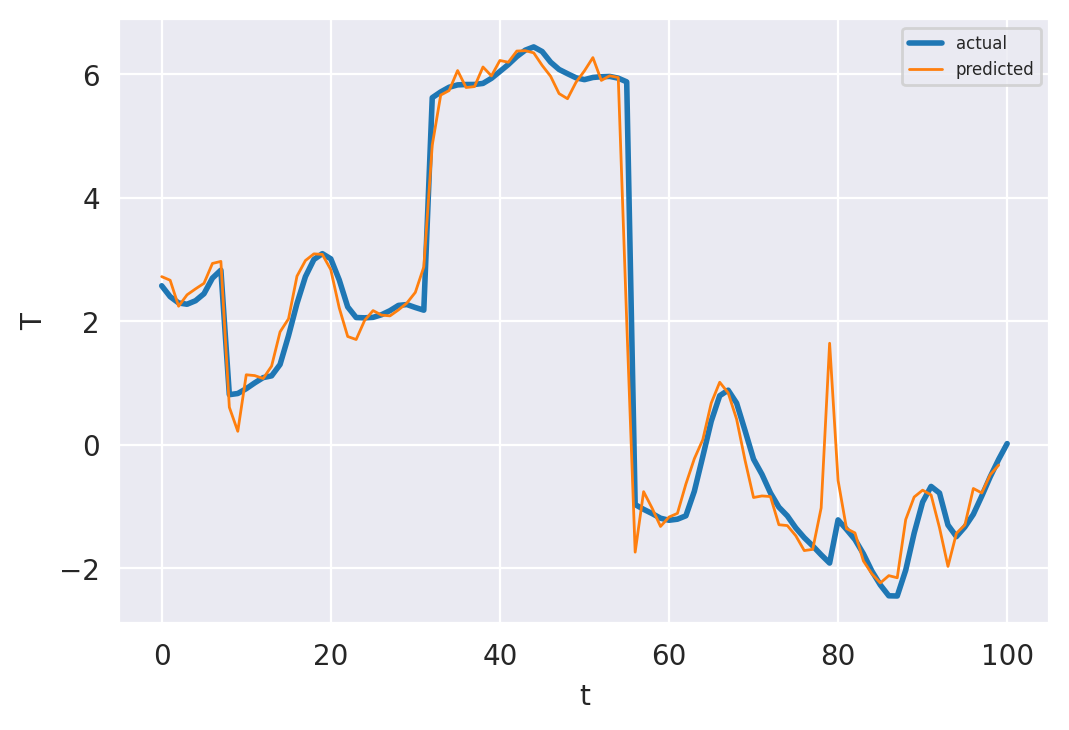

In [85]:
x = model.train_data.time_series[None, 1000:1000 + 101]
y = model.forward(x[:, :-1]).detach().cpu().numpy()

plt.plot(x[0, :, 0], lw=2, label="actual")
plt.plot(y[0, :, 0], lw=1, label="predicted")
plt.xlabel("t")
plt.ylabel("T")
plt.legend()

And now on the validation set:
Examine local behavior

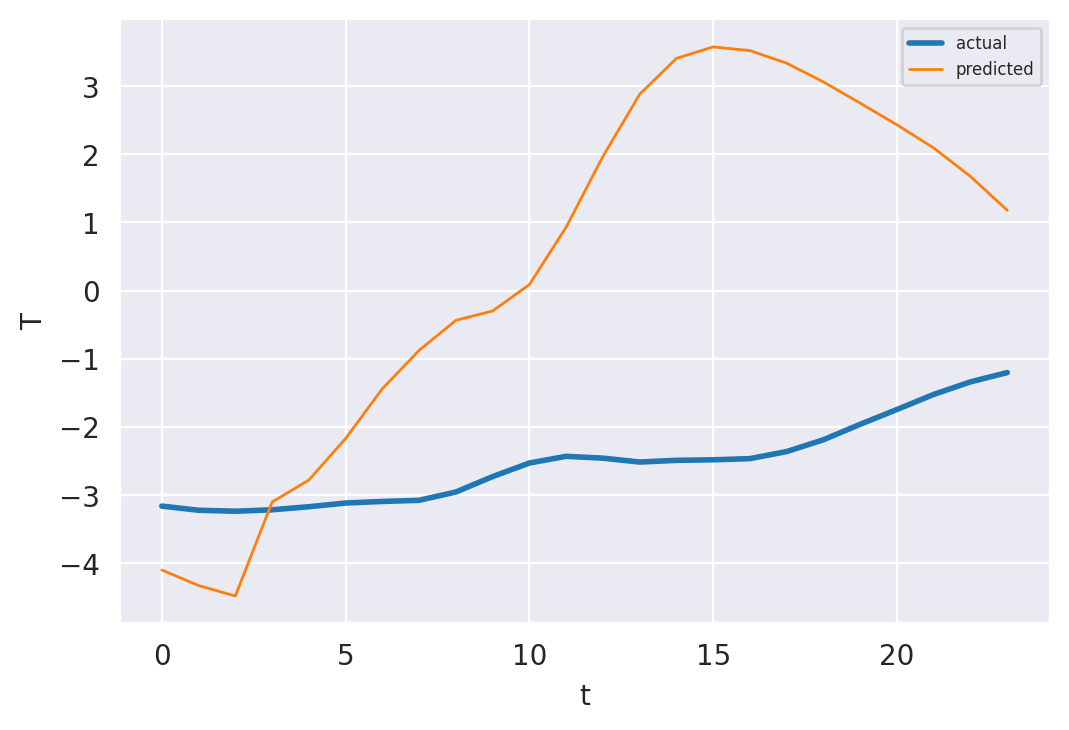

In [86]:
steps = 24
yhat = model.forecast(steps)

plt.plot(val_data[:steps, 0], lw=2, label="actual")
plt.plot(yhat[:, 0], lw=1, label="predicted")
plt.xlabel("t")
plt.ylabel("T")
plt.legend()

and global behavior

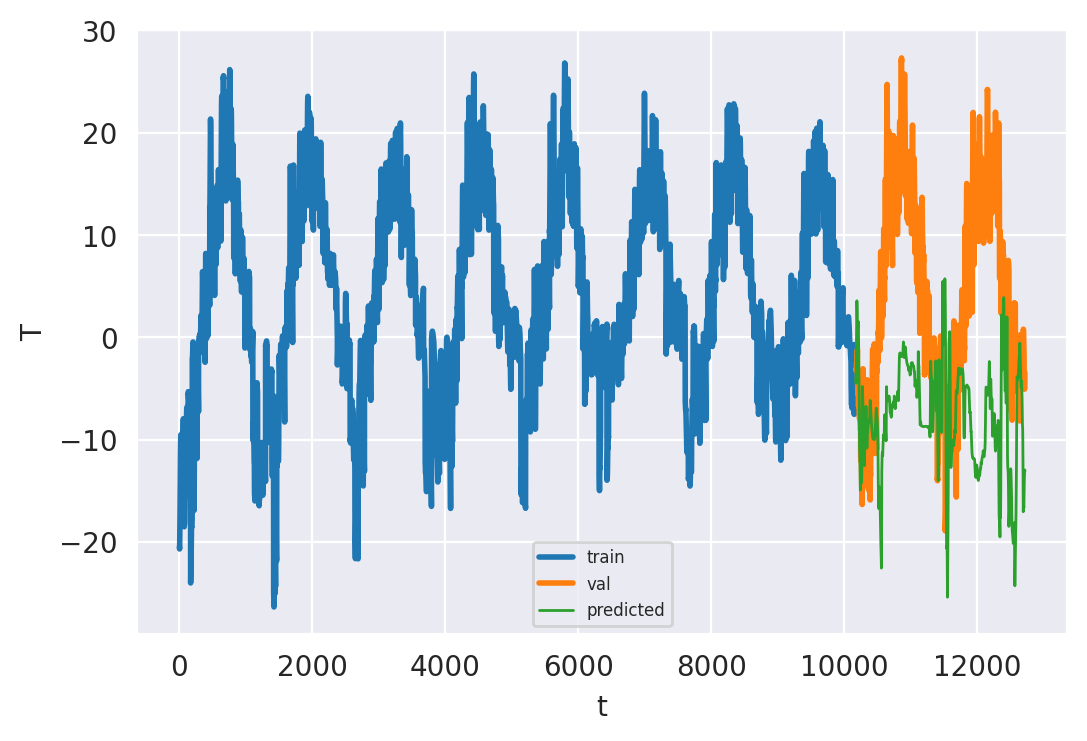

In [87]:
steps = len(val_data)
yhat = model.forecast(steps)

x = np.arange(len(train_data))
plt.plot(x, train_data[:, 0], lw=2, label="train")
x = np.arange(len(train_data), len(train_data) + len(val_data))
plt.plot(x, val_data[:, 0], lw=2, label="val")
plt.plot(x, yhat[:, 0], lw=1, label="predicted")
plt.xlabel("t")
plt.ylabel("T")
plt.legend()